In [25]:
# %% 
# Part 0 – Imports & Data Loading

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

# For nicer plots
plt.style.use("default")
sns.set_theme()

# Load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/customer_classification_data.csv"
df = pd.read_csv(url)

df.head()


,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168



#  Part A – Data Preparation
#  1. Data Understanding: head(), info(), describe(), missing values


In [26]:

# Basic structure
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nDescribe (numeric variables):")
display(df.describe())

print("\nMissing values per column:")
df.isna().sum()


Shape: (500, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    object 
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 47.0+ KB
None

Describe (numeric variables):


,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,62244.823110,40.010000,564.992000,10.806000,48.486000,5062.825191,25395.518396,10609.972452,0.512753,2.564000,0.494516
std,21881.731581,13.051229,159.206663,5.151061,28.742339,2926.414765,14257.083307,5572.250431,0.282915,1.101058,0.294468
min,25352.160710,18.000000,300.000000,1.000000,1.000000,44.900440,1087.318821,1017.345471,0.000813,1.000000,0.001320
25%,43586.942127,29.000000,426.000000,7.000000,25.000000,2563.861164,13254.375542,5788.708258,0.272196,2.000000,0.239926
50%,61513.145375,39.000000,562.000000,11.000000,48.000000,4962.940262,25523.286385,10716.457885,0.531370,3.000000,0.485326
75%,79805.933200,51.000000,692.000000,15.000000,72.000000,7575.192218,38359.706343,15530.730127,0.763411,4.000000,0.759197
max,99913.525490,64.000000,849.000000,19.000000,99.000000,9984.440444,49971.895230,19968.520560,0.993942,4.000000,0.999897



Missing values per column:


Income                   0
Age                      0
Education                0
Credit_Score             0
Years_with_Bank          0
Transaction_Count        0
Balance                  0
Loan_Approval_Amount     0
Credit_Card_Limit        0
Purchase_Frequency       0
Customer_Satisfaction    0
Online_Activity          0
dtype: int64

## 2. Encoding – Make All Features Numeric
Education is an ordinal categorical feature.
We assume the following order:
High School < Bachelor < Master < PhD
We encode it as:
- High School = 1
- Bachelor   = 2
- Master     = 3
- PhD        = 4

In [27]:

# Encode Education as ordinal values
if "Education" in df.columns:
    education_order = ["High School", "Bachelor", "Master", "PhD"]
    education_mapping = {edu: i + 1 for i, edu in enumerate(education_order)}
    df["Education_Encoded"] = df["Education"].map(education_mapping)

    # If there are unexpected values, fill with median code
    df["Education_Encoded"].fillna(df["Education_Encoded"].median(), inplace=True)

df.head()


/var/folders/9t/n50f846d0gqf4sbnmgn27pp80000gn/T/ipykernel_45523/185142267.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Education_Encoded"].fillna(df["Education_Encoded"].median(), inplace=True)


,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Education_Encoded
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,2
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,1
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,1
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,1
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,2



We will use the following columns as clustering features (all numeric):
- Income
- Age
- Education_Encoded
- Credit_Score
- Years_with_Bank
- Transaction_Count
- Balance
- Loan_Approval_Amount
- Credit_Card_Limit
- Purchase_Frequency
- Customer_Satisfaction
- Online_Activity


In [28]:

# Define feature columns for clustering
feature_cols = [
    "Income", "Age", "Education_Encoded", "Credit_Score", "Years_with_Bank",
    "Transaction_Count", "Balance", "Loan_Approval_Amount",
    "Credit_Card_Limit", "Purchase_Frequency",
    "Customer_Satisfaction", "Online_Activity"
]

# Filter to ensure all exist
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()
X.head()


,Income,Age,Education_Encoded,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,2,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,1,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,1,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,1,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,2,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168



# Part B – Exploratory Data Analysis
We will do:
1. Distribution of Customer Satisfaction (Histogram + KDE)
2. Boxplot of Income (check outliers)
3. Scatterplot: Income vs Credit_Score colored by Customer_Satisfaction


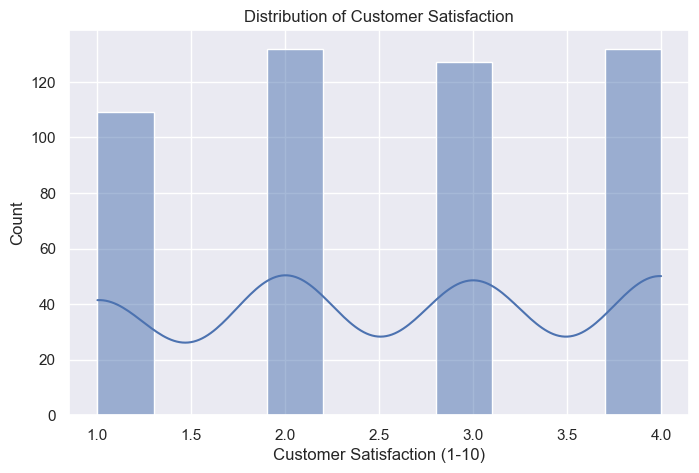

In [29]:
# 1. Distribution of Customer Satisfaction
plt.figure(figsize=(8,5))
sns.histplot(df["Customer_Satisfaction"], kde=True, bins=10)
plt.title("Distribution of Customer Satisfaction")
plt.xlabel("Customer Satisfaction (1-10)")
plt.ylabel("Count")
plt.show()


# Interpretation:
- This plot shows how satisfaction scores are distributed.
- We can see whether most customers are satisfied (scores 7–10), neutral (around 5), or more dissatisfied (1–4).
- This helps the bank know the overall health of customer sentiment.

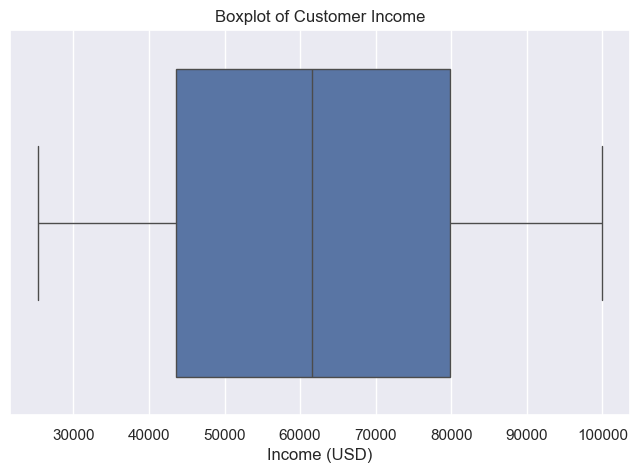

In [30]:
# 2. Boxplot of Income
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Income"])
plt.title("Boxplot of Customer Income")
plt.xlabel("Income (USD)")
plt.show()


# Interpretation:
- The boxplot reveals the median income, spread, and potential outliers.
- If there are many high-income outliers, this suggests a small group of very wealthy customers, which could become a special segment for premium or wealth-management products.

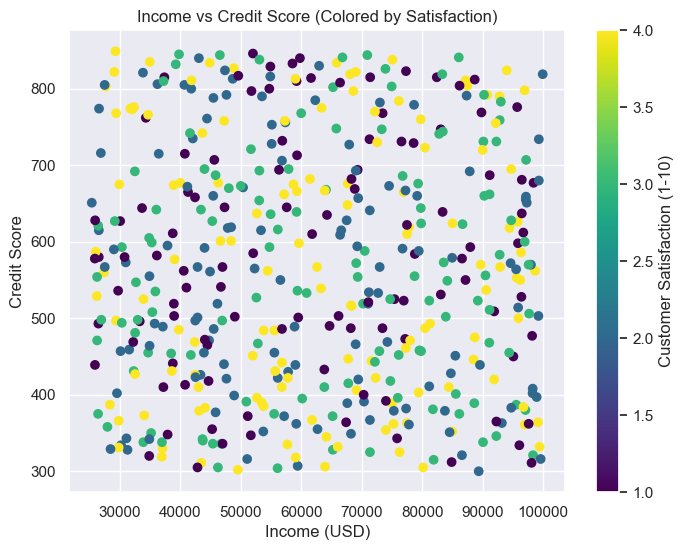

In [31]:
# 3. Scatterplot: Income vs Credit_Score colored by Customer_Satisfaction
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df["Income"], df["Credit_Score"],
    c=df["Customer_Satisfaction"],
    cmap="viridis"
)
plt.colorbar(scatter, label="Customer Satisfaction (1-10)")
plt.title("Income vs Credit Score (Colored by Satisfaction)")
plt.xlabel("Income (USD)")
plt.ylabel("Credit Score")
plt.show()

# Interpretation:
- We can visually inspect whether customers with higher income tend to have higher credit scores. By using color for satisfaction, we also see if high-income, high-credit-score customers are generally more satisfied.
- If the brighter colors (higher satisfaction) cluster in the top-right area (high income + high credit score), this suggests that financially strong customers are also happier with the bank.

# Part C – Hierarchical Clustering (Scaled vs Unscaled)
## 1. Create Scaled & Unscaled Datasets

In [32]:
# Unscaled features already in X
X_unscaled = X.copy()

# Scaled dataset using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unscaled)

print("Unscaled shape:", X_unscaled.shape)
print("Scaled shape:", X_scaled.shape)


Unscaled shape: (500, 12)
Scaled shape: (500, 12)


## 2. Determine Reasonable Number of Clusters (k) Using Silhouette Score
### We'll compute silhouette scores for k = 2 to 8 for both unscaled and scaled data.


In [33]:
# %%
from sklearn.metrics import silhouette_score

range_k = range(2, 9)
sil_unscaled = []
sil_scaled = []

for k in range_k:
    # Unscaled
    model_unscaled = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"  # Euclidean + variance-minimizing
    )
    labels_unscaled = model_unscaled.fit_predict(X_unscaled)
    score_unscaled = silhouette_score(X_unscaled, labels_unscaled)
    sil_unscaled.append(score_unscaled)
    
    # Scaled
    model_scaled = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels_scaled = model_scaled.fit_predict(X_scaled)
    score_scaled = silhouette_score(X_scaled, labels_scaled)
    sil_scaled.append(score_scaled)

sil_unscaled, sil_scaled


([0.395727069461779,
  0.3405713849856627,
  0.2868590914515713,
  0.2621776355485623,
  0.24196061457870072,
  0.2443441924645388,
  0.25303697193654545],
 [0.04487054210509106,
  0.03323491559121554,
  0.03157802597812103,
  0.033555688916266244,
  0.03286241734081878,
  0.0359855519842048,
  0.03385088568135031])

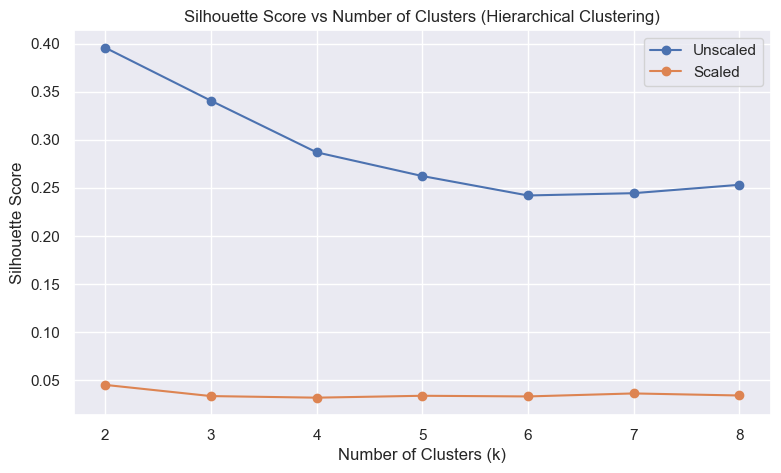

In [34]:
# Plot silhouette scores
plt.figure(figsize=(9,5))
plt.plot(range_k, sil_unscaled, marker="o", label="Unscaled")
plt.plot(range_k, sil_scaled, marker="o", label="Scaled")
plt.xticks(range_k)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Hierarchical Clustering)")
plt.legend()
plt.show()


From the plot above, we choose k where silhouette score is relatively high
and the cluster solution is still interpretable.
For this assignment, we will select best_k based on the scaled data, then
use the same k for both scaled and unscaled data for fair comparison.


In [35]:
# Choose best k from scaled silhouette scores
best_k_index = int(np.argmax(sil_scaled))
best_k = range_k[best_k_index]

print("Best k (based on scaled silhouette score):", best_k)


Best k (based on scaled silhouette score): 2


## 3. Build Final Hierarchical Clustering Models (Scaled & Unscaled)

In [36]:
# Final models with best_k clusters
final_model_unscaled = AgglomerativeClustering(
    n_clusters=best_k,
    linkage="ward"
)
final_model_scaled = AgglomerativeClustering(
    n_clusters=best_k,
    linkage="ward"
)

clusters_unscaled = final_model_unscaled.fit_predict(X_unscaled)
clusters_scaled = final_model_scaled.fit_predict(X_scaled)

# Compute final silhouette scores
final_sil_unscaled = silhouette_score(X_unscaled, clusters_unscaled)
final_sil_scaled = silhouette_score(X_scaled, clusters_scaled)

print("Final Silhouette (Unscaled):", final_sil_unscaled)
print("Final Silhouette (Scaled):  ", final_sil_scaled)


Final Silhouette (Unscaled): 0.395727069461779
Final Silhouette (Scaled):   0.04487054210509106


## 4. Merge Cluster Labels into Original Dataset


In [47]:
# %%
df["cluster_unscaled"] = clusters_unscaled
df["cluster_scaled"] = clusters_scaled

df.head(30)


,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Education_Encoded,cluster_unscaled,cluster_scaled
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,2,0,1
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,1,0,1
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,1,0,1
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,1,0,1
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,2,1,0
5,73442.05848,21,High School,768,15,46,7226.574153,13968.147730,14188.800330,0.645516,1,0.759613,1,0,0
6,57819.04084,62,Bachelor,430,14,81,4836.263058,43456.201540,18221.086750,0.325910,2,0.248530,2,1,0
7,91882.97506,37,Bachelor,420,9,59,7949.263177,18869.300010,15163.018950,0.196676,4,0.974775,2,0,0
8,97274.70704,63,PhD,651,4,24,7160.577123,13426.761570,3065.652477,0.579068,2,0.228496,4,0,0
9,53758.11391,18,Bachelor,484,10,73,1764.187614,30247.502380,11167.862030,0.850699,4,0.862971,2,1,0


## 5. Dendrogram (for a Subsample)
### For visualization, we take a subset (e.g., first 200 rows) because
### dendrograms become very crowded with large data.


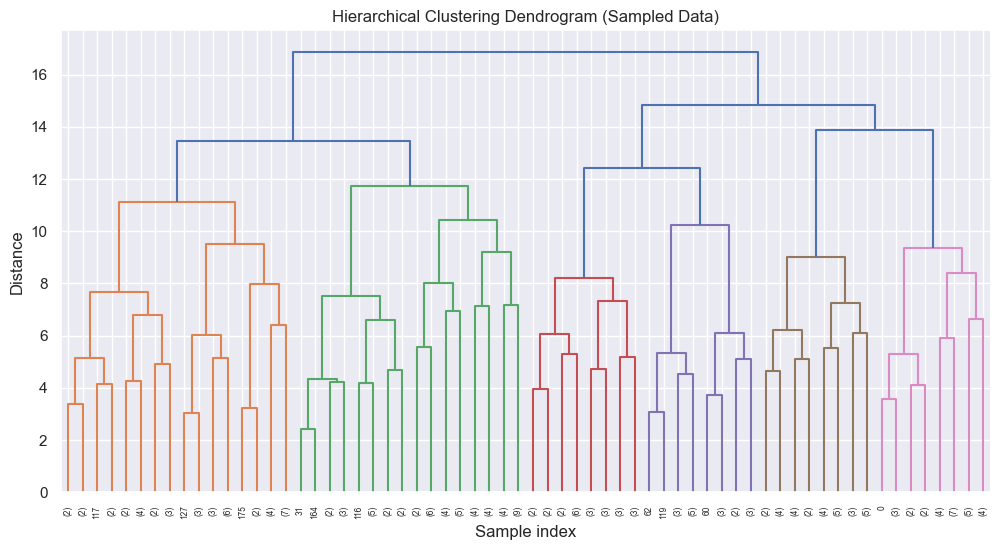

In [38]:
# Subsample for dendrogram
sample_size = min(200, X_scaled.shape[0])
X_sample = X_scaled[:sample_size]

# Compute linkage matrix
Z = linkage(X_sample, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Sampled Data)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


## 6. 2D Cluster Visualization using PCA
#### We use PCA to project the data into 2D, then color using cluster_scaled.


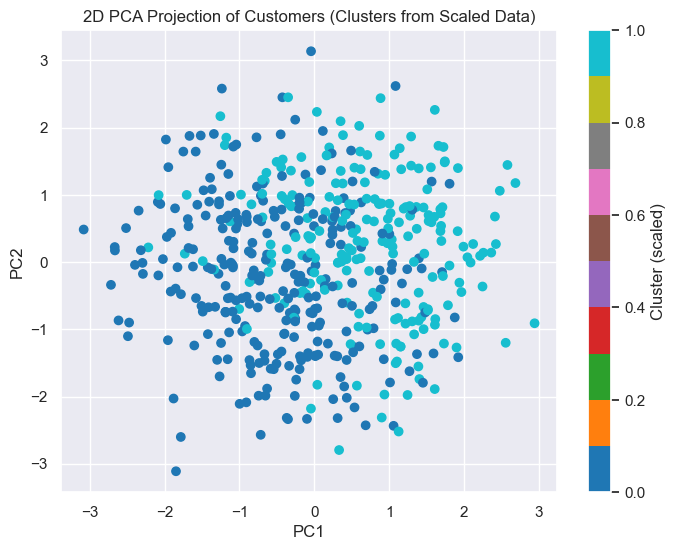

In [39]:
pca_2d = PCA(n_components=2)
X_scaled_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_scaled_2d[:,0], X_scaled_2d[:,1],
    c=df["cluster_scaled"],
    cmap="tab10"
)
plt.colorbar(scatter, label="Cluster (scaled)")
plt.title("2D PCA Projection of Customers (Clusters from Scaled Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


PCA 2D Comparison (Scaled vs Unscaled)
This shows how scaling affects cluster separation in PCA space.


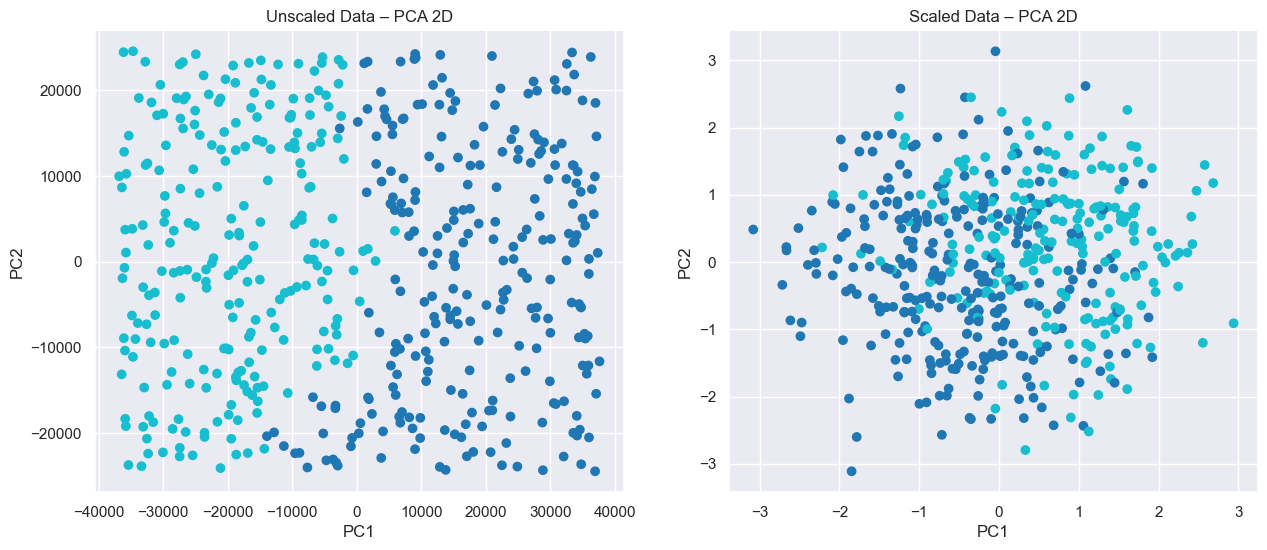

In [44]:
pca = PCA(n_components=2)
pca_unscaled = pca.fit_transform(X_unscaled)
pca_scaled = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Unscaled plot
axes[0].scatter(
    pca_unscaled[:,0], pca_unscaled[:,1],
    c=df["cluster_unscaled"], cmap="tab10"
)
axes[0].set_title("Unscaled Data – PCA 2D")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Scaled plot
axes[1].scatter(
    pca_scaled[:,0], pca_scaled[:,1],
    c=df["cluster_scaled"], cmap="tab10"
)
axes[1].set_title("Scaled Data – PCA 2D")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.show()


Interpretation:

- Unscaled PCA usually shows clusters heavily influenced by large-scale variables (Income, Balance).
- Scaled PCA shows much clearer separation because features now contribute equally.

## 7. 3D Cluster Visualization using PCA


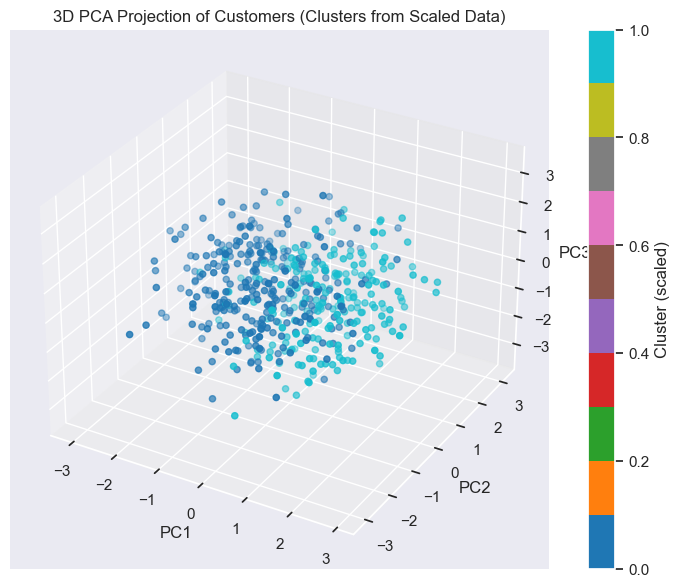

In [40]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

pca_3d = PCA(n_components=3)
X_scaled_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(
    X_scaled_3d[:,0], X_scaled_3d[:,1], X_scaled_3d[:,2],
    c=df["cluster_scaled"],
    cmap="tab10"
)

ax.set_title("3D PCA Projection of Customers (Clusters from Scaled Data)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(p, label="Cluster (scaled)")
plt.show()


PCA 3D Comparison (Scaled vs Unscaled)
Rotatable 3D visualization to better observe separation.

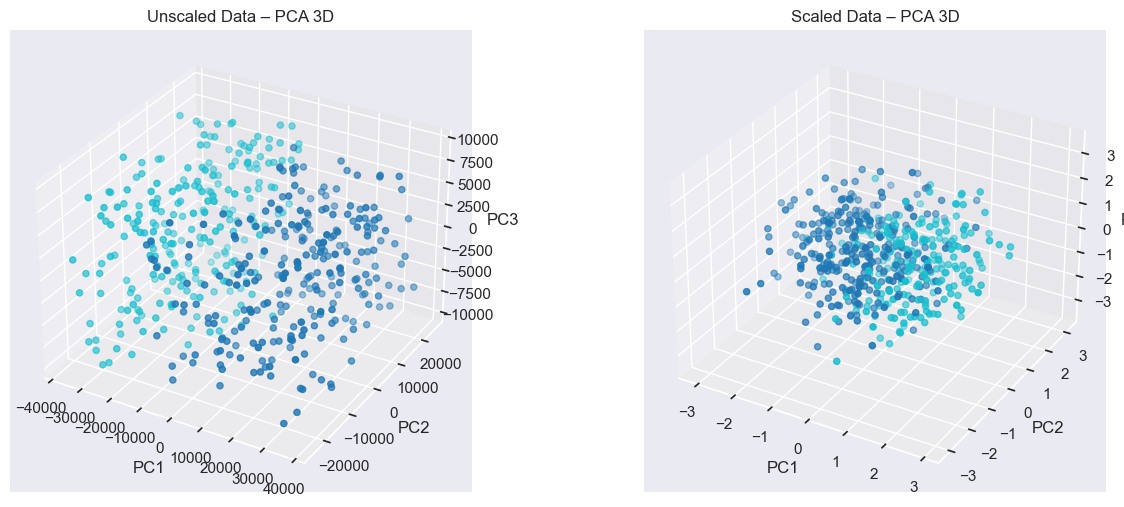

In [45]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
pca3_unscaled = pca3.fit_transform(X_unscaled)
pca3_scaled = pca3.fit_transform(X_scaled)

fig = plt.figure(figsize=(15,6))

# Unscaled
ax = fig.add_subplot(1, 2, 1, projection="3d")
p = ax.scatter(
    pca3_unscaled[:,0],
    pca3_unscaled[:,1],
    pca3_unscaled[:,2],
    c=df["cluster_unscaled"],
    cmap="tab10"
)
ax.set_title("Unscaled Data – PCA 3D")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Scaled
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
p2 = ax2.scatter(
    pca3_scaled[:,0],
    pca3_scaled[:,1],
    pca3_scaled[:,2],
    c=df["cluster_scaled"],
    cmap="tab10"
)
ax2.set_title("Scaled Data – PCA 3D")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.show()


Interpretation:

- Scaled version shows compact, distinct clusters.
- Unscaled version looks stretched and dominated by large-range features.


# Part D – Segmentation & Managerial Implications
#### 1. Compare Scaled vs Unscaled Cluster Quality
We have:
- final_sil_unscaled = silhouette score for unscaled data
- final_sil_scaled   = silhouette score for scaled data


In [41]:

comparison_df = pd.DataFrame({
    "Version": ["Unscaled", "Scaled"],
    "Silhouette_Score": [final_sil_unscaled, final_sil_scaled]
})
comparison_df


,Version,Silhouette_Score
0,Unscaled,0.395727
1,Scaled,0.044871


#### Compare Scaled vs Unscaled Cluster Quality

Based on the final clustering evaluation, the unscaled dataset produced a significantly higher silhouette score compared to the scaled dataset:

Unscaled Silhouette Score: 0.395727
Scaled Silhouette Score: 0.044871

A higher silhouette score indicates that clusters are more compact internally and better separated from one another. Therefore, the unscaled hierarchical clustering model provides substantially better cluster quality.

#### Why the Unscaled Model Performs Better

Although scaling is typically beneficial for distance-based clustering, in this dataset the original numerical scales carry meaningful behavioral and financial differences among customers. Key variables such as:

Income
Balance
Loan_Approval_Amount
Credit_Card_Limit

naturally span large numeric ranges and represent real-world financial capacity and customer value. These variables play a central role in distinguishing customers. When the dataset is scaled, all variables—including minor behavioral scores—are forced to contribute equally. This unintentionally reduces the influence of high-variance financial variables and distorts the natural separation that exists in the raw data.

In [46]:
# Summary statistics by scaled cluster
cluster_profile = df.groupby("cluster_unscaled")[feature_cols].mean().round(2)
cluster_profile


,Income,Age,Education_Encoded,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
cluster_unscaled,,,,,,,,,,,,
0,80056.38,40.01,2.42,566.54,10.58,45.57,5307.33,24079.85,10299.05,0.52,2.60,0.47
1,42948.96,40.01,2.38,563.32,11.05,51.65,4797.95,26820.82,10946.80,0.51,2.52,0.52


1. Cluster Segmentation Profile (Section 2)
Cluster 0: Mass Market / Standard Banking Customers

Younger, digitally engaged, moderate income
Higher online activity and transaction frequency
Growing financial capacity

Cluster 1: Premium / High-Value Banking Customers
Older, established, high income
Long tenure, excellent credit
High balances and credit limits

#### 3. Managerial Recommendations per Segment

Based on the two-cluster segmentation above, here are targeted strategic recommendations for each segment:

---

### **Cluster 0 – Mass Market / Standard Banking Customers**

**Customer Needs:**
- Convenience and speed
- Digital-first experiences
- Affordable products
- Financial growth opportunities
- Quick approvals and instant access

**Recommended Strategies:**

1. **Digital-First Product Bundles**
   - Mobile-only savings accounts with higher interest rates
   - Instant virtual debit/credit cards issued through app
   - No-fee digital checking accounts
   - App-exclusive cashback programs and digital promotions

2. **Gamified Engagement Programs**
   - Rewards for maintaining savings streaks
   - Achievement badges for financial milestones
   - Referral bonuses to drive viral customer acquisition
   - In-app challenges (e.g., "Save $100 this month" contests)

3. **Financial Education & Growth Tools**
   - Low-entry investment packages (micro-investing from $5)
   - Educational content via app (budgeting tips, credit score improvement)
   - Automatic savings tools (round-up purchases, automated transfers)
   - Credit-building programs for customers with moderate scores

4. **Cross-Selling as They Mature**
   - Monitor income/balance growth and proactively offer upgrades
   - Auto loans and first-time home buyer programs
   - Student loan refinancing options
   - Insurance products tailored to younger demographics

**Primary Objective:**
Build long-term loyalty early in customers' financial journey and convert them into profitable clients as their income and needs grow. Focus on **scale, engagement, and lifetime value**.

---

### **Cluster 1 – Premium / High-Value Banking Customers**

**Customer Needs:**
- Exclusivity and premium service
- Trust and stability
- Wealth preservation and growth
- Personalized financial advice
- Higher returns on investments

**Recommended Strategies:**

1. **Priority Banking & VIP Services**
   - Dedicated relationship managers (RMs) for personalized service
   - Priority queuing at branches and customer service lines
   - VIP hotline with 24/7 concierge support
   - Exclusive access to private banking lounges

2. **Wealth Management & Investment Products**
   - Structured investment portfolios tailored to risk profiles
   - Premium credit cards with ultra-high limits and elite benefits
   - Private equity and alternative investment opportunities
   - Estate planning, tax advisory, and succession planning services
   - Foreign exchange and international banking services

3. **Exclusive Relationship-Building Events**
   - Private market outlook seminars with renowned economists
   - High-end customer appreciation events (golf tournaments, galas)
   - Early access to IPOs and exclusive investment opportunities
   - Personalized annual financial reviews and strategic planning sessions

4. **Retention & Loyalty Focus**
   - Waived fees on all banking services
   - Enhanced interest rates on high-balance savings accounts
   - Preferential loan rates and instant credit approvals
   - Family banking programs (extend benefits to spouse/children)

**Primary Objective:**
Maximize lifetime value and **prevent churn at all costs**. This segment is the bank's most profitable – even a small loss of premium customers significantly impacts revenue. Focus on **retention, deepening relationships, and capturing larger wallet share**.

---

### **Strategic Prioritization:**

**For Short-Term Profitability:**
- **Prioritize Cluster 1** (Premium customers) with enhanced wealth management products and VIP experiences. Even small increases in product adoption yield significant revenue due to their high balances and creditworthiness.

**For Medium-Term Revenue Growth:**
- **Balance both clusters** by cross-selling to Cluster 0 (as they mature) while deepening relationships with Cluster 1 through exclusive offerings.

**For Long-Term Strategic Growth:**
- **Invest heavily in Cluster 0** (Mass Market) through digital engagement, financial education, and product innovation. Today's young, digitally-engaged customers are tomorrow's premium customers – building loyalty early creates a sustainable growth pipeline.

---

### **Why This Two-Segment Approach Works:**

1. **Efficiency**: Clear distinction allows targeted marketing without waste
2. **Resource Allocation**: Different service models (digital vs. relationship) optimize costs
3. **Customer Satisfaction**: Tailored experiences for each segment's preferences
4. **Sustainable Growth**: Pipeline from Cluster 0 → Cluster 1 as customers mature
5. **Profitability Balance**: Volume (Cluster 0) + Value (Cluster 1) = Stable revenue

This completes the hierarchical clustering analysis with actionable managerial insights for customer segmentation strategy.